In [67]:
import numpy as np
import pandas as pd
import math
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

def printVar (varname, var):

    print(varname)
    print(var)

def saveArray (name, array):

    pd.DataFrame(array).to_csv("savedVariables/" + name + ".csv", index=False, header=None)


In [68]:
# Solve the 2D Navier-Cauchy equation using a segregated finite volume method

# Define mesh geometry and boundary conditions

Lx = .01 #width of domain
Ly = .01 #height of domain

fac = 1

# tr_left_x = -1e-6*fac      #u boundary condition at the left boundary
# tr_left_y =  1e-6*0     #v boundary condition at the left boundary

# tr_right_x = +1e-6*fac    #u boundary condition at the right boundary
# tr_right_y = 1e-6*0     #v boundary condition at the right boundary

# tr_top_x = 1e-6*0       #u boundary condition at the top boundary
# tr_top_y = +1e-6*fac       #v boundary condition at the top boundary

# tr_bottom_x = -1e-6*0    #u boundary condition at the bottom boundary 
# tr_bottom_y = -1e-6*fac    #v boundary condition at the bottom boundary

nx = 8          #number of control volumes in the x-direction
ny = 8          #number of control volumes in the y-direction

u_bottom = -1e-6
v_bottom = -1e-6*0

u_top = 1e-6
v_top = 1e-6*0

u_left = -1e-6*0
v_left = -1e-6

u_right = 1e-6*0
v_right = 1e-6


In [69]:
class edge_U:

    def __init__(self, edges, xy):

        if xy == "x":
            if edges[0] == "b":
                self.BC = u_bottom
            if edges[0] == "t":
                self.BC = u_top
            if edges[0] == "l":
                self.BC = u_left
            if edges[0] == "r":
                self.BC = u_right

        if xy == "y":
            if edges[0] == "b":
                self.BC = v_bottom
            if edges[0] == "t":
                self.BC = v_top
            if edges[0] == "l":
                self.BC = v_left
            if edges[0] == "r":
                self.BC = v_right

edge_U(["b"], "x").BC

-1e-06

In [70]:
sys.path.append("/home/scottlevie/pythonsolver/tractionBCs/Classes/")

from index_and_direction import dim

# dim().nx = 9
# dim().ny = 9

# print(dim().nx)

In [71]:
print(dim().nx)

8


In [72]:
from index_and_direction import index
from index_and_direction import boundary_point_index
from index_and_direction import cell_index
from index_and_direction import displacement

In [73]:
# Define material properties

rho = 8050         #density of steel in kg/m^3
mu = 78*10e9       #shear modulus in Pa
K = 1.6*10e11      #bulk modulus in Pa

Lambda = K - (2/3)*mu

#print(Lambda)

In [74]:
## Define required variables

tf = 0.01           #total time in seconds
dx = Lx/nx          #length of each control volume in the x-direction
dy = Ly/ny          #length of each control volume in the y-direction
dt = tf/10          #size of time steps
Sfx = dy            #area vector x component (Area of East and West Faces)
Sfy = dx            #area vector y component (Area of North and South Faces)


In [75]:
## Define  position and time vectors

t = np.array(np.arange(0,tf, dt))        #time vector (could possibly use a list)
x = np.zeros((1,nx+2))   #position vector defining the center points of the control volumes in the x-direction.
x[0,nx+1] = Lx
x[0,1:nx+1] = np.arange(dx/2,Lx,dx)

t = np.array(np.arange(0,tf, dt))        #time vector (could possibly use a list)
y = np.zeros((1,ny+2))   #position vector defining the center points of the control volumes in the y-direction.
y[0,ny+1] = Ly
y[0,1:ny+1] = np.arange(dy/2,Ly,dy)

In [76]:
## Define required displacement matrices and b vector

u_new = np.zeros([(ny+2)*(nx+2),2])         #unknown displacements at t + 1    (Column 1 = x, Column2 = y)
u_old = np.zeros([(ny+2)*(nx+2),2])         #displacement at time t
u_old_old = np.zeros([(ny+2)*(nx+2),2])     #displacement at time t - 1

#rhs vector
b_x = np.zeros([(ny+2)*(nx+2),1])
b_y = np.zeros([(ny+2)*(nx+2),1])

## X equation:

In [77]:
class A(index, displacement):

    val = "value that stays in class without changning with instance"

    def __init__(self, xy):

        if xy == "x":

            self.a_P = (rho*dx*dy/(dt**2))+((4*mu+2*Lambda)*Sfx)/dx + ((2*mu)*Sfy)/dy
            
            self.a_N = + A.coef(xy, "N", "u")*(Sfy)/dy
            self.a_S = - A.coef(xy, "S", "u")*(Sfy)/dy
            self.a_E = + A.coef(xy, "E", "u")*(Sfx)/dx
            self.a_W = - A.coef(xy, "W", "u")*(Sfx)/dx

        if xy == "y":

            self.a_P = (rho*dx*dy/(dt**2))+((4*mu+2*Lambda)*Sfy)/dy + ((2*mu)*Sfx)/dx 
            self.a_N = + A.coef(xy, "N", "v")*(Sfy)/dy
            self.a_S = - A.coef(xy, "S", "v")*(Sfy)/dy
            self.a_E = + A.coef(xy, "E", "v")*(Sfx)/dx
            self.a_W = - A.coef(xy, "W", "v")*(Sfx)/dx

    def createMatrix(self):

        A_no_boundary = np.zeros([(ny+2)*(nx+2), (ny+2)*(nx+2)])
        A_no_boundary = csr_matrix(A_no_boundary)  

        for j in np.arange(2, ny):     

            for k in np.arange((j*(nx+2)+2), (j*(nx+2)+nx)):  
                
                A_no_boundary[k,k] = self.a_P
                A_no_boundary[k,index(k).n] = -self.a_N
                A_no_boundary[k,index(k).s] = -self.a_S
                A_no_boundary[k, index(k).e] = -self.a_E
                A_no_boundary[k, index(k).w] = -self.a_W

        return A_no_boundary

    # b temporal term
    def b_temp(u_old, u_old_old, k, xy):

        if xy == "x":
            b_temporal_term = (rho/(dt**2))*( 2*(u_old[k,0])*dx*dy - u_old_old[k,0]*dx*dy)
        if xy == "y":
            b_temporal_term = (rho/(dt**2))*( 2*(u_old[k,1])*dx*dy - u_old_old[k,1]*dx*dy)
        
        return b_temporal_term
    
    def b_diff(k, xy, u_previous):

        if xy == "x":
            uv = "v"
        if xy == "y":
            uv = "u"

        b_diffusion = (
                                Sfy*A.coef(xy, "N", uv)*(
                                    (A.corner("NE", uv, u_previous, k) - A.corner("NW", uv, u_previous, k))
                                    /dx)
                                + 
                                Sfy*A.coef(xy, "S", uv)*(
                                    (A.corner("SE", uv, u_previous, k) - A.corner("SW", uv, u_previous, k))
                                    /dx)
                                +
                                Sfx*A.coef(xy, "E", uv)*(
                                    (A.corner("NE", uv, u_previous, k) - A.corner("SE", uv, u_previous, k))
                                    /dy)
                                +
                                Sfx*A.coef(xy, "W", uv)*(
                                    (A.corner("NW", uv, u_previous, k) - A.corner("SW", uv, u_previous, k))
                                    /dy)
        )

        return b_diffusion
    
    def corner(corner_placement, uv, u_previous, k):
        if uv == "u":
            uv_i = 0
        elif uv == "v":
            uv_i = 1

        disp = displacement(k, u_previous, uv_i)

        if corner_placement == "NE":
            return (1/4)*(disp.P + disp.NE + disp.N + disp.E)
        if corner_placement == "SE":
            return (1/4)*(disp.P + disp.SE + disp.S + disp.E)
        if corner_placement == "SW":
            return (1/4)*(disp.P + disp.SW + disp.S + disp.W)
        if corner_placement == "NW":
            return (1/4)*(disp.P + disp.NW + disp.N + disp.W)


    
    def coef(xy, face, uv):
        # could have and statements
        if xy == "x":
            if face == "N":
                if uv == "u":
                    return mu
                if uv == "v":
                    return mu
            if face == "S":
                if uv == "u":
                    return - mu
                if uv == "v":
                    return - mu
            if face == "E":
                if uv == "u":
                    return 2*mu + Lambda
                if uv == "v":
                    return Lambda
            if face == "W":
                if uv == "u":
                    return - (2*mu + Lambda)
                if uv == "v":
                    return - Lambda

        elif xy == "y":
            if face == "N":
                if uv == "u":
                    return Lambda
                if uv == "v":
                    return 2*mu + Lambda
            if face == "S":
                if uv == "u":
                    return - Lambda
                if uv == "v":
                    return - (2*mu + Lambda)
            if face == "E":
                if uv == "u":
                    return mu
                if uv == "v":
                    return mu
            if face == "W":
                if uv == "u":
                    return - mu
                if uv == "v":
                    return - mu

u_previous = u_new

# A.b_diff(25, "x", u_previous)

In [78]:
class boundaryCellTraction(A):

    def __init__(self, edges, xy):
        
        sw_S, sw_N, sw_W, sw_E = 1, 1, 1, 1

        for edge in edges:
            if edge == "b": sw_S = 0
            if edge == "t": sw_N = 0
            if edge == "l": sw_W = 0
            if edge == "r": sw_E = 0
        
        self.a_P = (rho*dx*dy/(dt**2)) + A(xy).a_N*sw_N + A(xy).a_S**sw_S + A(xy).a_E*sw_E + A(xy).a_W*sw_W
        
        self.a_N = A(xy).a_N 
        self.a_S = A(xy).a_S 
        self.a_E = A(xy).a_E 
        self.a_W = A(xy).a_W 

        # self.a_faces = A(xy).a_N*sw_N + A(xy).a_S*sw_S + A(xy).a_E*sw_E + A(xy).a_W*sw_W 

    def b_temp(u_old, u_old_old, k, xy):      
        return A.b_temp(u_old, u_old_old, k, xy)
    
    def b_diff(edges, k, xy, u_previous):

        if xy == "x":
            uv = "v"
        if xy == "y":
            uv = "u"
            
        N_term =(
                    Sfy*A.coef(xy, "N", uv)*(
                    (boundaryCellTraction.corner(edges, "NE", uv, u_previous, k) - boundaryCellTraction.corner(edges, "NW", uv, u_previous, k))
                    /dx)
                )
        S_term =(
                    Sfy*A.coef(xy, "S", uv)*(
                        (boundaryCellTraction.corner(edges, "SE", uv, u_previous, k) - boundaryCellTraction.corner(edges, "SW", uv, u_previous, k))
                        /dx)
                ) 
        E_term =(
                    Sfx*A.coef(xy, "E", uv)*(
                        (boundaryCellTraction.corner(edges, "NE", uv, u_previous, k) - boundaryCellTraction.corner(edges, "SE", uv, u_previous, k))
                        /dy)
                ) 
        W_term =(
                    Sfx*A.coef(xy, "W", uv)*(
                        (boundaryCellTraction.corner(edges, "NW", uv, u_previous, k) - boundaryCellTraction.corner(edges, "SW", uv, u_previous, k))
                        /dy)
                )

        for edge in edges:

            if (edge == "b") & (xy == "x") : S_term =  Sfy*tr_bottom_x  
            if (edge == "b") & (xy == "y") : S_term =  Sfy*tr_bottom_y  
            if (edge == "t") & (xy == "x") : N_term =  Sfy*tr_top_x  
            if (edge == "t") & (xy == "y") : N_term =  Sfy*tr_top_y  
            if (edge == "l") & (xy == "x") : W_term =  Sfx*tr_left_x  
            if (edge == "l") & (xy == "y") : W_term =  Sfx*tr_left_y  
            if (edge == "r") & (xy == "x") : E_term =  Sfx*tr_right_x  
            if (edge == "r") & (xy == "y") : E_term =  Sfx*tr_right_y        

        b_diffusion = (N_term + S_term + E_term + W_term)

        return b_diffusion
    
    def corner(edges, corner_placement, uv, u_previous, k):

        if uv == "u":
            uv_i = 0
        elif uv == "v":
            uv_i = 1

        disp = displacement(k, u_previous, uv_i)

        if corner_placement == "NE":
            corner =  (1/4)*(disp.P + disp.NE + disp.N + disp.E)
        if corner_placement == "SE":
            corner =  (1/4)*(disp.P + disp.SE + disp.S + disp.E)
        if corner_placement == "SW":
            corner =  (1/4)*(disp.P + disp.SW + disp.S + disp.W)
        if corner_placement == "NW":
            corner =  (1/4)*(disp.P + disp.NW + disp.N + disp.W)

        for edge in edges:
            if (edge == "b") & (corner_placement == "SE"):
                corner =  (1/2)*(disp.SE + disp.S)
            if (edge == "b") & (corner_placement == "SW"):
                corner =  (1/2)*(disp.SW + disp.S)

            if (edge == "t") & (corner_placement == "NE"):
                corner =  (1/2)*(disp.NE + disp.N)
            if (edge == "t") & (corner_placement == "NW"):
                corner =  (1/2)*(disp.NW + disp.N)

            if (edge == "l") & (corner_placement == "NW"):
                corner =  (1/2)*(disp.NW + disp.W)
            if (edge == "l") & (corner_placement == "SW"):
                corner =  (1/2)*(disp.SW + disp.W)

            if (edge == "r") & (corner_placement == "NE"):
                corner =  (1/2)*(disp.NE + disp.E)
            if (edge == "r") & (corner_placement == "SE"):
                corner =  (1/2)*(disp.SE + disp.E)
        
        return corner

# boundaryCellTraction.b_diff(["b", "l"], 14, "x", u_previous)
   

In [79]:
class boundaryCellTraction(A):

    def __init__(self, edges, xy):
        
        sw_S, sw_N, sw_W, sw_E = 1, 1, 1, 1

        for edge in edges:
            if edge == "b": sw_S = 0
            if edge == "t": sw_N = 0
            if edge == "l": sw_W = 0
            if edge == "r": sw_E = 0
        
        self.a_P = (rho*dx*dy/(dt**2)) + A(xy).a_N*sw_N + A(xy).a_S*sw_S + A(xy).a_E*sw_E + A(xy).a_W*sw_W
        
        self.a_N = A(xy).a_N 
        self.a_S = A(xy).a_S 
        self.a_E = A(xy).a_E 
        self.a_W = A(xy).a_W 

        # self.a_faces = A(xy).a_N*sw_N + A(xy).a_S*sw_S + A(xy).a_E*sw_E + A(xy).a_W*sw_W 

    def b_temp(u_old, u_old_old, k, xy):      
        return A.b_temp(u_old, u_old_old, k, xy)
    
    def b_diff(edges, k, xy, u_previous):

        if xy == "x":
            uv = "v"
        if xy == "y":
            uv = "u"
            
        N_term =(
                    Sfy*A.coef(xy, "N", uv)*(
                    (boundaryCellTraction.corner(edges, "NE", uv, u_previous, k) - boundaryCellTraction.corner(edges, "NW", uv, u_previous, k))
                    /dx)
                )
        S_term =(
                    Sfy*A.coef(xy, "S", uv)*(
                        (boundaryCellTraction.corner(edges, "SE", uv, u_previous, k) - boundaryCellTraction.corner(edges, "SW", uv, u_previous, k))
                        /dx)
                ) 
        E_term =(
                    Sfx*A.coef(xy, "E", uv)*(
                        (boundaryCellTraction.corner(edges, "NE", uv, u_previous, k) - boundaryCellTraction.corner(edges, "SE", uv, u_previous, k))
                        /dy)
                ) 
        W_term =(
                    Sfx*A.coef(xy, "W", uv)*(
                        (boundaryCellTraction.corner(edges, "NW", uv, u_previous, k) - boundaryCellTraction.corner(edges, "SW", uv, u_previous, k))
                        /dy)
                )

        for edge in edges:

            if (edge == "b") & (xy == "x") : S_term =  Sfy*tr_bottom_x  
            if (edge == "b") & (xy == "y") : S_term =  Sfy*tr_bottom_y  
            if (edge == "t") & (xy == "x") : N_term =  Sfy*tr_top_x  
            if (edge == "t") & (xy == "y") : N_term =  Sfy*tr_top_y  
            if (edge == "l") & (xy == "x") : W_term =  Sfx*tr_left_x  
            if (edge == "l") & (xy == "y") : W_term =  Sfx*tr_left_y  
            if (edge == "r") & (xy == "x") : E_term =  Sfx*tr_right_x  
            if (edge == "r") & (xy == "y") : E_term =  Sfx*tr_right_y        

        b_diffusion = (N_term + S_term + E_term + W_term)

        return b_diffusion
    
    def corner(edges, corner_placement, uv, u_previous, k):

        if uv == "u":
            uv_i = 0
        elif uv == "v":
            uv_i = 1

        disp = displacement(k, u_previous, uv_i)

        if corner_placement == "NE":
            corner =  (1/4)*(disp.P + disp.NE + disp.N + disp.E)
        if corner_placement == "SE":
            corner =  (1/4)*(disp.P + disp.SE + disp.S + disp.E)
        if corner_placement == "SW":
            corner =  (1/4)*(disp.P + disp.SW + disp.S + disp.W)
        if corner_placement == "NW":
            corner =  (1/4)*(disp.P + disp.NW + disp.N + disp.W)

        for edge in edges:
            if (edge == "b") & (corner_placement == "SE"):
                corner =  (1/2)*(disp.SE + disp.S)
            if (edge == "b") & (corner_placement == "SW"):
                corner =  (1/2)*(disp.SW + disp.S)

            if (edge == "t") & (corner_placement == "NE"):
                corner =  (1/2)*(disp.NE + disp.N)
            if (edge == "t") & (corner_placement == "NW"):
                corner =  (1/2)*(disp.NW + disp.N)

            if (edge == "l") & (corner_placement == "NW"):
                corner =  (1/2)*(disp.NW + disp.W)
            if (edge == "l") & (corner_placement == "SW"):
                corner =  (1/2)*(disp.SW + disp.W)

            if (edge == "r") & (corner_placement == "NE"):
                corner =  (1/2)*(disp.NE + disp.E)
            if (edge == "r") & (corner_placement == "SE"):
                corner =  (1/2)*(disp.SE + disp.E)
        
        return corner

# boundaryCellTraction.b_diff(["b", "l"], 14, "x", u_previous)
   

In [80]:
class boundaryCellDisplacement(A):

    def __init__(self, edges, xy):
        
        sw_S, sw_N, sw_W, sw_E = 1, 1, 1, 1

        for edge in edges:
            if edge == "b": sw_S = 2
            if edge == "t": sw_N = 2
            if edge == "l": sw_W = 2
            if edge == "r": sw_E = 2
        
        self.a_P = (rho*dx*dy/(dt**2)) + A(xy).a_N*sw_N + A(xy).a_S**sw_S + A(xy).a_E*sw_E + A(xy).a_W*sw_W
        
        self.a_N = A(xy).a_N*sw_N
        self.a_S = A(xy).a_S*sw_S
        self.a_E = A(xy).a_E*sw_E
        self.a_W = A(xy).a_W*sw_W

    def b_temp(u_old, u_old_old, k, xy):      
        return A.b_temp(u_old, u_old_old, k, xy)
    
    def b_diff(edges, k, xy, u_previous):

        if xy == "x":
            uv = "v"
        if xy == "y":
            uv = "u"
            
        N_term =(
                    Sfy*A.coef(xy, "N", uv)*(
                    (boundaryCellDisplacement.corner(edges, "NE", uv, u_previous, k) - boundaryCellDisplacement.corner(edges, "NW", uv, u_previous, k))
                    /dx)
                )
        S_term =(
                    Sfy*A.coef(xy, "S", uv)*(
                        (boundaryCellDisplacement.corner(edges, "SE", uv, u_previous, k) - boundaryCellDisplacement.corner(edges, "SW", uv, u_previous, k))
                        /dx)
                ) 
        E_term =(
                    Sfx*A.coef(xy, "E", uv)*(
                        (boundaryCellDisplacement.corner(edges, "NE", uv, u_previous, k) - boundaryCellDisplacement.corner(edges, "SE", uv, u_previous, k))
                        /dy)
                ) 
        W_term =(
                    Sfx*A.coef(xy, "W", uv)*(
                        (boundaryCellDisplacement.corner(edges, "NW", uv, u_previous, k) - boundaryCellDisplacement.corner(edges, "SW", uv, u_previous, k))
                        /dy)
                ) 

        b_diffusion = (N_term + S_term + E_term + W_term)

        return b_diffusion
    
    def corner(edges, corner_placement, uv, u_previous, k):

        if uv == "u":
            uv_i = 0
        elif uv == "v":
            uv_i = 1

        disp = displacement(k, u_previous, uv_i)

        if corner_placement == "NE":
            corner =  (1/4)*(disp.P + disp.NE + disp.N + disp.E)
        if corner_placement == "SE":
            corner =  (1/4)*(disp.P + disp.SE + disp.S + disp.E)
        if corner_placement == "SW":
            corner =  (1/4)*(disp.P + disp.SW + disp.S + disp.W)
        if corner_placement == "NW":
            corner =  (1/4)*(disp.P + disp.NW + disp.N + disp.W)

        for edge in edges:
            if (edge == "b") & (corner_placement == "SE"):
                corner =  (1/2)*(disp.SE + disp.S)
            if (edge == "b") & (corner_placement == "SW"):
                corner =  (1/2)*(disp.SW + disp.S)

            if (edge == "t") & (corner_placement == "NE"):
                corner =  (1/2)*(disp.NE + disp.N)
            if (edge == "t") & (corner_placement == "NW"):
                corner =  (1/2)*(disp.NW + disp.N)

            if (edge == "l") & (corner_placement == "NW"):
                corner =  (1/2)*(disp.NW + disp.W)
            if (edge == "l") & (corner_placement == "SW"):
                corner =  (1/2)*(disp.SW + disp.W)

            if (edge == "r") & (corner_placement == "NE"):
                corner =  (1/2)*(disp.NE + disp.E)
            if (edge == "r") & (corner_placement == "SE"):
                corner =  (1/2)*(disp.SE + disp.E)

        if len(edges) < 0:

            if (edges[0] == "b") & (edges[1] == "l") & (corner_placement == "SW"):
                corner = disp.SW 
            if (edges[0] == "b") & (edges[1] == "r") & (corner_placement == "SE"):
                corner = disp.SE
            if (edges[0] == "t") & (edges[1] == "l") & (corner_placement == "NW"):
                corner = disp.NW
            if (edges[0] == "t") & (edges[1] == "r") & (corner_placement == "NE"):
                corner = disp.NE

        
        return corner

# boundaryCellDisplacement.b_diff(["b", "l"], 14, "x", u_previous)
   

In [81]:
class boundaryPointTraction(A):

    def __init__(self, edges, xy):    # The order matters for edges, bottom left corner on the bottom is : ["b", "l"]
        
        sw_S, sw_N, sw_W, sw_E = 0, 0, 0, 0

        if edges[0] == "b": sw_S = 1
        if edges[0] == "t": sw_N = 1
        if edges[0] == "l": sw_W = 1
        if edges[0] == "r": sw_E = 1
        
        a_P = (A(xy).a_N*sw_N + A(xy).a_S**sw_S + A(xy).a_E*sw_E + A(xy).a_W*sw_W)*2/(Sfy)
        
        a_N = A(xy).a_N*2/(Sfy) # are terms cancel in derivation
        a_S = A(xy).a_S*2/(Sfy)
        a_E = A(xy).a_E*2/(Sfx)
        a_W = A(xy).a_W*2/(Sfx)

        if edges[0] == "b":
            self.a_N = a_P
            self.a_P = a_S
        if edges[0] == "t":
            self.a_S = a_P
            self.a_P = a_N
        if edges[0] == "l":
            self.a_E = a_P
            self.a_P = a_W
        if edges[0] == "r":
            self.a_W = a_P
            self.a_P = a_E
    
    def b_diff(edges, k, xy, u_previous):

        if xy == "x":
            uv = "v"
        if xy == "y":
            uv = "u"
            
        def N_term():
            
            N_term =( A.coef(xy, "N", uv)*(
                    (boundaryPointTraction.corner(edges, "E", uv, u_previous, k) - boundaryPointTraction.corner(edges, "W", uv, u_previous, k))
                    /dx)
            )

            return N_term

        def S_term():
            
            S_term =(
                    A.coef(xy, "S", uv)*(
                        (boundaryPointTraction.corner(edges, "E", uv, u_previous, k) - boundaryPointTraction.corner(edges, "W", uv, u_previous, k))
                        /dx)
                ) 
            return S_term
        def E_term():
            
            E_term =(
                    A.coef(xy, "E", uv)*(
                        (boundaryPointTraction.corner(edges, "N", uv, u_previous, k) - boundaryPointTraction.corner(edges, "S", uv, u_previous, k))
                        /dy)
                ) 
            return E_term
        def W_term():
            
            W_term =(
                        A.coef(xy, "W", uv)*(
                        (boundaryPointTraction.corner(edges, "N", uv, u_previous, k) - boundaryPointTraction.corner(edges, "S", uv, u_previous, k))
                        /dy)
                )
                
            return W_term

        # This can be tidied up/shortened

        if (edges[0] == "b") & (xy == "x") : b_diffusion =  tr_bottom_x  + N_term()
        if (edges[0] == "b") & (xy == "y") : b_diffusion =  tr_bottom_y  + N_term()
        if (edges[0] == "t") & (xy == "x") : b_diffusion =  tr_top_x + S_term()
        if (edges[0] == "t") & (xy == "y") : b_diffusion =  tr_top_y + S_term()
        if (edges[0] == "l") & (xy == "x") : b_diffusion =  tr_left_x + E_term()
        if (edges[0] == "l") & (xy == "y") : b_diffusion =  tr_left_y + E_term()
        if (edges[0] == "r") & (xy == "x") : b_diffusion =  tr_right_x + W_term()
        if (edges[0] == "r") & (xy == "y") : b_diffusion =  tr_right_y + W_term()  

        return b_diffusion
    
    def corner(edges, corner_placement, uv, u_previous, k):

        if uv == "u":
            uv_i = 0
        elif uv == "v":
            uv_i = 1

        disp = displacement(k, u_previous, uv_i)


        if corner_placement == "E":
            corner =  (1/2)*(disp.E + disp.P)
        if corner_placement == "W":
            corner =  (1/2)*(disp.W + disp.P)
        if  corner_placement == "N":
            corner =  (1/2)*(disp.N + disp.P)
        if  corner_placement == "S":
            corner =  (1/2)*(disp.S + disp.P)

        if len(edges) > 1:

            if (edges[1] == "r") & (corner_placement == "E"):
                    corner =  disp.E
            if (edges[1] == "l") & (corner_placement == "W"):
                    corner =  disp.W
            if (edges[1] == "t") & (corner_placement == "N"):
                    corner =  disp.N
            if (edges[1] == "b") & (corner_placement == "S"):
                    corner =  disp.S
        
        return corner
# boundaryCellDisplacement.b_diff(["b", "l"], 14, "x", u_previous)
   

In [82]:
## Time loop

!rm -r savedVariables
! mkdir savedVariables

for time in t:

    print("\nTime = " + str(time))
    
    # Set number of maximum iterations for convergence
    
    icorr = 1
    maxcorr = 100000

    # Make directory

    ! mkdir savedVariables/{time}
    
    while True:
    # for iteration in [1]:
            
        u_previous = u_new #store latest guess values

        A_x = A("x").createMatrix()
        
        for k in np.arange(0,(nx+2)*(ny+2)):   # k is the cell number

            xy = "x"

            U = displacement(k, u_previous, 0)
            V = displacement(k, u_previous, 1)

            #Bottom left corner coefficients
               
            if cell_index().bottom_left_corner(k):
                sides = ["b", "l"]

                #print(str(k) + ": Bottom left corner coefficients")

                #ap
                A_x[k,k] = boundaryCellDisplacement(sides, xy).a_P

                #an
                A_x[k,index(k).n] = - boundaryCellDisplacement(side, xy).a_N        
                #as
                A_x[k,index(k).s] = - boundaryCellDisplacement(side, xy).a_S   
                #ae
                A_x[k, index(k).e] = - boundaryCellDisplacement(side, xy).a_E
                #aw
                A_x[k, index(k).w] = - boundaryCellDisplacement(side, xy).a_W

                b_x[k] =(
                            boundaryCellDisplacement.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellDisplacement.b_diff(sides, k, xy, u_previous)
                        )   

            #Bottom right corner coefficients
                
            elif  cell_index().bottom_right_corner(k):
                sides = ["b", "r"]

                #print(str(k) + ": Bottom right corner coefficients")

                #ap
                A_x[k,k] = boundaryCellDisplacement(sides, xy).a_P

                #an
                A_x[k,index(k).n] = - boundaryCellDisplacement(side, xy).a_N        
                #as
                A_x[k,index(k).s] = - boundaryCellDisplacement(side, xy).a_S   
                #ae
                A_x[k, index(k).e] = - boundaryCellDisplacement(side, xy).a_E
                #aw
                A_x[k, index(k).w] = - boundaryCellDisplacement(side, xy).a_W

                b_x[k] =(
                            boundaryCellDisplacement.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellDisplacement.b_diff(sides, k, xy, u_previous)                          
                        ) 

            # Top Left Corner Coeficients
                
            elif  cell_index().top_left_corner(k):
                sides = ["t", "l"]

                #print(str(k) + ":Top Left corner coefficients")

                #ap                
                A_x[k,k] = boundaryCellDisplacement(sides, xy).a_P
                
                #an
                A_x[k,index(k).n] = - boundaryCellDisplacement(side, xy).a_N        
                #as
                A_x[k,index(k).s] = - boundaryCellDisplacement(side, xy).a_S   
                #ae
                A_x[k, index(k).e] = - boundaryCellDisplacement(side, xy).a_E
                #aw
                A_x[k, index(k).w] = - boundaryCellDisplacement(side, xy).a_W
                
                b_x[k] =(
                            boundaryCellDisplacement.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellDisplacement.b_diff(sides, k, xy, u_previous)  
                        )
                
            # Top right corner coefficients
                
            elif  cell_index().top_right_corner(k):   
                sides = ["t", "r"]

                #print(str(k) + ":Top right corner coefficients")

                #ap
                A_x[k,k] = boundaryCellDisplacement(sides, xy).a_P

                #an
                A_x[k,index(k).n] = - boundaryCellDisplacement(side, xy).a_N        
                #as
                A_x[k,index(k).s] = - boundaryCellDisplacement(side, xy).a_S   
                #ae
                A_x[k, index(k).e] = - boundaryCellDisplacement(side, xy).a_E
                #aw
                A_x[k, index(k).w] = - boundaryCellDisplacement(side, xy).a_W

                b_x[k] =(
                            boundaryCellDisplacement.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellDisplacement.b_diff(sides, k, xy, u_previous)
                        )
                
            # Center Bottom Boundaries

            elif  cell_index().center_bottom(k):
                side = "b"

                #print(str(k) + ": Bottom Center Coefficents for Cell")

                #ap
                A_x[k,k] = boundaryCellDisplacement(side, xy).a_P

                #an
                A_x[k,index(k).n] = - boundaryCellDisplacement(side, xy).a_N        
                #as
                A_x[k,index(k).s] = - boundaryCellDisplacement(side, xy).a_S   
                #ae
                A_x[k, index(k).e] = - boundaryCellDisplacement(side, xy).a_E
                #aw
                A_x[k, index(k).w] = - boundaryCellDisplacement(side, xy).a_W

                b_x[k] =(
                            boundaryCellDisplacement.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellDisplacement.b_diff(side, k, xy, u_previous)
                        )                                 

            # Center Top Boundaries

            elif cell_index().center_top(k):
                side = "t"

                #print(str(k) + ": Top Center Coefficents for Cell")

                #ap
                A_x[k,k] = boundaryCellDisplacement(side, xy).a_P
                #an
                A_x[k,index(k).n] = - boundaryCellDisplacement(side, xy).a_N
                #as
                A_x[k,index(k).s] = - boundaryCellDisplacement(side, xy).a_S                   
                #ae
                A_x[k, index(k).e] = - boundaryCellDisplacement(side, xy).a_E  
                #aw
                A_x[k, index(k).w] = - boundaryCellDisplacement(side, xy).a_W 

                b_x[k] =(
                            boundaryCellDisplacement.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellDisplacement.b_diff(side, k, xy, u_previous)
                        )
            
            # Center Left Boundaries

            elif  cell_index().center_left(k):
                side = "l"

                #print(str(k) + ": Left Center Coefficents for Cell")

                #ap
                A_x[k,k] = boundaryCellDisplacement(side, xy).a_P
                #an
                A_x[k,index(k).n] = - boundaryCellDisplacement(side, xy).a_N            
                #as
                A_x[k,index(k).s] = - boundaryCellDisplacement(side, xy).a_S
                #ae
                A_x[k,index(k).e] = - boundaryCellDisplacement(side, xy).a_E
                #aw
                A_x[k,index(k).w] = - boundaryCellDisplacement(side, xy).a_W

                b_x[k] =(
                            boundaryCellDisplacement.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellDisplacement.b_diff(side, k, xy, u_previous)
                        )

            # Center Right Boundaries

            elif  cell_index().center_right(k):
                side = "r"

                #print(str(k) + ": Right Center Coefficents for Cell")

                #ap
                A_x[k,k] = boundaryCellDisplacement(side, xy).a_P
                #an
                A_x[k,index(k).n] = - boundaryCellDisplacement(side, xy).a_N            
                #as
                A_x[k,index(k).s] = - boundaryCellDisplacement(side, xy).a_S
                #ae
                A_x[k,index(k).e] = - boundaryCellDisplacement(side, xy).a_E
                #aw
                A_x[k,index(k).w] = - boundaryCellDisplacement(side, xy).a_W

                b_x[k] =(
                            boundaryCellDisplacement.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellDisplacement.b_diff(side, k, xy, u_previous)
                        )

            #### Points on Boundary ####

            # Center Bottom

            elif boundary_point_index().center_bottom(k):
                edges = ["b"]

                A_x[k,k] = 1
                b_x[k] = edge_U(edges, xy).BC


            # Center Top

            elif boundary_point_index().center_top(k):
                edges = ["t"]

                A_x[k,k] = 1
                b_x[k] = edge_U(edges, xy).BC
                
            # Center Left

            elif boundary_point_index().center_left(k):
                edges = ["l"]

                A_x[k,k] = 1
                b_x[k] = edge_U(edges, xy).BC

            # Center Right

            elif boundary_point_index().center_right(k):
                edges = ["r"]

                A_x[k,k] = 1
                b_x[k] = edge_U(edges, xy).BC 

            # Bottom Left: Bottom

            elif boundary_point_index().bottom_left_bottom(k):
                edges = ["b", "l"]

                A_x[k,k] = 1
                b_x[k] = edge_U(edges, xy).BC

            # Bottom Left: Left

            elif boundary_point_index().bottom_left_left(k):
                edges = ["l", "b"]

                A_x[k,k] = 1
                b_x[k] = edge_U(edges, xy).BC
            
            # Bottom Right: Right

            elif boundary_point_index().bottom_right_right(k):
                edges = ["r", "b"]

                A_x[k,k] = 1
                b_x[k] = edge_U(edges, xy).BC

            # Bottom Right: Bottom

            elif boundary_point_index().bottom_right_bottom(k):
                edges = ["b", "r"]

                A_x[k,k] = 1
                b_x[k] = edge_U(edges, xy).BC

            # Top Left: Left

            elif boundary_point_index().top_left_left(k):
                edges = ["l", "t"]

                A_x[k,k] = 1
                b_x[k] = edge_U(edges, xy).BC

            # Top Left: Top

            elif boundary_point_index().top_left_top(k):
                edges = ["t", "l"]

                A_x[k,k] = 1
                b_x[k] = edge_U(edges, xy).BC

            # Top Right: Right

            elif boundary_point_index().top_right_right(k):
                edges = ["r", "t"]

                A_x[k,k] = 1
                b_x[k] = edge_U(edges, xy).BC

            # Top Right: Top
            
            elif boundary_point_index().top_right_top(k):
                edges = ["t", "r"]

                A_x[k,k] = 1
                b_x[k] = edge_U(edges, xy).BC
                        
            # Corner Points

            elif boundary_point_index().bottom_left_corner(k):

                #print(str(k) + ": Bottom Left Corner Point on Boundary")

                # A_x[k,k] = 4

                # A_x[k,index(k).n] = 2 
                # A_x[k,index(k).e] = 2

                # A_x[k,index(k).ne] = -15

                # A_x[k,index(k).dir(["n", "n"])] = 2 
                # A_x[k,index(k).dir(["e", "e"])] = 2

                # A_x[k,index(k).dir(["n", "ne"])] = 1
                # A_x[k,index(k).dir(["ne", "ne"])] = 1
                # A_x[k,index(k).dir(["e", "ne"])] = 1

                # b_x[k] = 0

                edges = ["b"]

                A_x[k,k] = 1
                b_x[k] = edge_U(edges, xy).BC

            elif boundary_point_index().bottom_right_corner(k):
                #print(str(k) + ": Bottom Right Corner Point on Boundary")
                # A_x[k,k] = 4

                # A_x[k,index(k).n] = 2 
                # A_x[k,index(k).w] = 2

                # A_x[k,index(k).nw] = -15

                # A_x[k,index(k).dir(["n", "n"])] = 2 
                # A_x[k,index(k).dir(["w", "w"])] = 2

                # A_x[k,index(k).dir(["n", "nw"])] = 1
                # A_x[k,index(k).dir(["nw", "nw"])] = 1
                # A_x[k,index(k).dir(["w", "nw"])] = 1

                edges = ["b"]

                A_x[k,k] = 1
                b_x[k] = edge_U(edges, xy).BC

            elif boundary_point_index().top_left_corner(k):
                #print(str(k) + ": Top Left Corner Point on Boundary")
                # A_x[k,k] = 4

                # A_x[k,index(k).s] = 2 
                # A_x[k,index(k).e] = 2

                # A_x[k,index(k).se] = -15

                # A_x[k,index(k).dir(["s", "s"])] = 2 
                # A_x[k,index(k).dir(["e", "e"])] = 2

                # A_x[k,index(k).dir(["s", "se"])] = 1
                # A_x[k,index(k).dir(["se", "se"])] = 1
                # A_x[k,index(k).dir(["e", "se"])] = 1

                # b_x[k] = 0
                edges = ["t"]

                A_x[k,k] = 1
                b_x[k] = edge_U(edges, xy).BC

            elif boundary_point_index().top_right_corner(k):
                #print(str(k) + ": Top Right Corner Point on Boundary")
                # A_x[k,k] = 4

                # A_x[k,index(k).s] = 2 
                # A_x[k,index(k).w] = 2

                # A_x[k,index(k).sw] = -15

                # A_x[k,index(k).dir(["s", "s"])] = 2 
                # A_x[k,index(k).dir(["w", "w"])] = 2

                # A_x[k,index(k).dir(["s", "sw"])] = 1
                # A_x[k,index(k).dir(["sw", "sw"])] = 1
                # A_x[k,index(k).dir(["w", "sw"])] = 1

                b_x[k] = 0
                edges = ["t"]

                A_x[k,k] = 1
                b_x[k] = edge_U(edges, xy).BC

                
            else:

                # print(str(k) + ": NO BC Cell")

                b_x[k] = (
                            A.b_temp(u_old, u_old_old, k, "x")
                            +
                            A.b_diff(k, "x", u_previous)
                        )

        # saveArray(str(time) + "/A_x_" + str(icorr) , A_x.todense())   
        # saveArray(str(time) + "/b_x_" + str(icorr), b_x)  

        ## Solve the x-equation
        
        Ux = spsolve(A_x, b_x)
        Ux = np.array(Ux)

        # #print(Ux)

        saveArray(str(time) + "/Ux_" + str(icorr), Ux)
        
        ## Prepare matrix A and b vector for the y-equation
        
        A_y = A("y").createMatrix()
        
        for k in np.arange(0,(nx+2)*(ny+2)):   # j is the cell number

            xy = "y"


            U = displacement(k, u_previous, 0)
            V = displacement(k, u_previous, 1)
 
            #Bottom left corner coefficients
            
            if cell_index().bottom_left_corner(k):
                sides = ["b", "l"]

                #print(str(k) + ": Bottom left corner coefficients")

                #ap
                A_y[k,k] = boundaryCellDisplacement(sides, xy).a_P
                #an
                A_y[k,index(k).n] = - boundaryCellDisplacement(sides, xy).a_N
                #as
                A_y[k,index(k).s] = - boundaryCellDisplacement(sides, xy).a_S
                #ae
                A_y[k, index(k).e] = - boundaryCellDisplacement(sides, xy).a_E
                #aw
                A_y[k, index(k).w] = - boundaryCellDisplacement(sides, xy).a_W

                b_y[k] =(
                            boundaryCellDisplacement.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellDisplacement.b_diff(sides, k, xy, u_previous)
                        )   
            
            #Bottom right corner coefficients
                
            elif  cell_index().bottom_right_corner(k):
                sides = ["b", "r"]

                #print(str(k) + ": Bottom right corner coefficients")

                #ap
                A_y[k,k] = boundaryCellDisplacement(sides, xy).a_P
                #an
                A_y[k,index(k).n] = - boundaryCellDisplacement(sides, xy).a_N
                #as
                A_y[k,index(k).s] = - boundaryCellDisplacement(sides, xy).a_S
                #ae
                A_y[k, index(k).e] = - boundaryCellDisplacement(sides, xy).a_E
                #aw
                A_y[k, index(k).w] = - boundaryCellDisplacement(sides, xy).a_W

                b_y[k] =(
                            boundaryCellDisplacement.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellDisplacement.b_diff(sides, k, xy, u_previous)   
                        )
                     
            #Top left corner coefficients
                
            elif  cell_index().top_left_corner(k):
                sides = ["t", "l"]

                #print(str(k) + ":Top Left corner coefficients")

                #ap
                A_y[k,k] = boundaryCellDisplacement(sides, xy).a_P
                #an
                A_y[k,index(k).n] = - boundaryCellDisplacement(sides, xy).a_N
                #as
                A_y[k,index(k).s] = - boundaryCellDisplacement(sides, xy).a_S
                #ae
                A_y[k, index(k).e] = - boundaryCellDisplacement(sides, xy).a_E
                #aw
                A_y[k, index(k).w] = - boundaryCellDisplacement(sides, xy).a_W
                
                b_y[k] =(
                            boundaryCellDisplacement.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellDisplacement.b_diff(sides, k, xy, u_previous)  
                        )
                
            #Top right corner coefficients
                
            elif  cell_index().top_right_corner(k):   
                sides = ["t", "r"]

                #print(str(k) + ":Top right corner coefficients")
                
                #ap
                A_y[k,k] = boundaryCellDisplacement(sides, xy).a_P
                #an
                A_y[k,index(k).n] = - boundaryCellDisplacement(sides, xy).a_N
                #as
                A_y[k,index(k).s] = - boundaryCellDisplacement(sides, xy).a_S
                #ae
                A_y[k, index(k).e] = - boundaryCellDisplacement(sides, xy).a_E
                #aw
                A_y[k, index(k).w] = - boundaryCellDisplacement(sides, xy).a_W

                b_y[k] =(
                            boundaryCellDisplacement.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellDisplacement.b_diff(sides, k, xy, u_previous) 
                        )
            
            # Center Bottom Boundaries

            elif  cell_index().center_bottom(k):
                side = "b"

                #print(str(k) + ": Bottom Center Coefficents for Cell")

                #ap
                A_y[k,k] = boundaryCellDisplacement(side, xy).a_P
                #an
                A_y[k,index(k).n] = - boundaryCellDisplacement(side, xy).a_N   
                #an
                A_y[k,index(k).s] = - boundaryCellDisplacement(side, xy).a_S         
                #ae
                A_y[k, index(k).e] = - boundaryCellDisplacement(side, xy).a_E
                #aw
                A_y[k, index(k).w] = - boundaryCellDisplacement(side, xy).a_W

                b_y[k] =(
                            boundaryCellDisplacement.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellDisplacement.b_diff(side, k, xy, u_previous)
                        )

            # Center Top Boundaries

            elif cell_index().center_top(k):
                side = "t"

                #print(str(k) + ": Top Center Coefficents for Cell")

                #ap
                A_y[k,k] = boundaryCellDisplacement(side, xy).a_P
                #an
                A_y[k,index(k).n] = - boundaryCellDisplacement(side, xy).a_N
                #as
                A_y[k,index(k).s] = - boundaryCellDisplacement(side, xy).a_S                   
                #ae
                A_y[k, index(k).e] = - boundaryCellDisplacement(side, xy).a_E  
                #aw
                A_y[k, index(k).w] = - boundaryCellDisplacement(side, xy).a_W 

                b_y[k] =(
                            boundaryCellDisplacement.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellDisplacement.b_diff(side, k, xy, u_previous)
                        )

            # Center Left Boundaries

            elif  cell_index().center_left(k):

                side = "l"

                #print(str(k) + ": Left Center Coefficents for Cell")

                #ap
                A_y[k,k] = boundaryCellDisplacement(side, xy).a_P
                #an
                A_y[k,index(k).n] = - boundaryCellDisplacement(side, xy).a_N            
                #as
                A_y[k,index(k).s] = - boundaryCellDisplacement(side, xy).a_S
                #ae
                A_y[k,index(k).e] = - boundaryCellDisplacement(side, xy).a_E
                #aw
                A_y[k,index(k).w] = - boundaryCellDisplacement(side, xy).a_W

                b_y[k] =(
                            boundaryCellDisplacement.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellDisplacement.b_diff(side, k, xy, u_previous)
                        )

            # Center Right Boundaries

            elif  cell_index().center_right(k):
                side = "r"

                #print(str(k) + ": Right Center Coefficents for Cell")

                #ap
                A_y[k,k] = boundaryCellDisplacement(side, xy).a_P
                #an
                A_y[k,index(k).n] = - boundaryCellDisplacement(side, xy).a_N            
                #as
                A_y[k,index(k).s] = - boundaryCellDisplacement(side, xy).a_S
                #ae
                A_y[k,index(k).e] = - boundaryCellDisplacement(side, xy).a_E
                #aw
                A_y[k,index(k).w] = - boundaryCellDisplacement(side, xy).a_W

                b_y[k] =(
                            boundaryCellDisplacement.b_temp(u_old, u_old_old, k, xy)
                            +
                            boundaryCellDisplacement.b_diff(side, k, xy, u_previous)
                        )


            #### Points on Boundary ####

            # Center Bottom

            elif boundary_point_index().center_bottom(k):
                edges = ["b"]

                A_y[k,k] = 1
                b_y[k] = edge_U(edges, xy).BC

            # Center Top

            elif boundary_point_index().center_top(k):
                edges = ["t"]

                A_y[k,k] = 1
                b_y[k] = edge_U(edges, xy).BC
                
            # Center Left

            elif boundary_point_index().center_left(k):
                edges = ["l"]

                A_y[k,k] = 1
                b_y[k] = edge_U(edges, xy).BC

            # Center Right

            elif boundary_point_index().center_right(k):
                edges = ["r"]

                A_y[k,k] = 1
                b_y[k] = edge_U(edges, xy).BC

            # Bottom Left: Bottom

            elif boundary_point_index().bottom_left_bottom(k):
                edges = ["b", "l"]

                A_y[k,k] = 1
                b_y[k] = edge_U(edges, xy).BC

            elif boundary_point_index().bottom_left_left(k):
                edges = ["l", "b"]

                A_y[k,k] = 1
                b_y[k] = edge_U(edges, xy).BC
            
            # Bottom Right: Right

            elif boundary_point_index().bottom_right_right(k):
                edges = ["r", "b"]

                A_y[k,k] = 1
                b_y[k] = edge_U(edges, xy).BC

            # Bottom Right: Bottom

            elif boundary_point_index().bottom_right_bottom(k):
                edges = ["b", "r"]

                A_y[k,k] = 1
                b_y[k] = edge_U(edges, xy).BC

            # Top Left: Left

            elif boundary_point_index().top_left_left(k):
                edges = ["l", "t"]

                A_y[k,k] = 1
                b_y[k] = edge_U(edges, xy).BC

            # Top Left: Top

            elif boundary_point_index().top_left_top(k):
                edges = ["t", "l"]

                A_y[k,k] = 1
                b_y[k] = edge_U(edges, xy).BC

            # Top Right: Right

            elif boundary_point_index().top_right_right(k):
                edges = ["r", "t"]

                A_y[k,k] = 1
                b_y[k] = edge_U(edges, xy).BC

            # Top Right: Top
            
            elif boundary_point_index().top_right_top(k):
                edges = ["t", "r"]

                A_y[k,k] = 1
                b_y[k] = edge_U(edges, xy).BC

            # # Corner Points
            elif boundary_point_index().bottom_left_corner(k):

                #print(str(k) + ": Bottom Left Corner Point on Boundary")

                # A_y[k,k] = 4

                # A_y[k,index(k).n] = 2 
                # A_y[k,index(k).e] = 2

                # A_y[k,index(k).ne] = -15

                # A_y[k,index(k).dir(["n", "n"])] = 2 
                # A_y[k,index(k).dir(["e", "e"])] = 2

                # A_y[k,index(k).dir(["n", "ne"])] = 1
                # A_y[k,index(k).dir(["ne", "ne"])] = 1
                # A_y[k,index(k).dir(["e", "ne"])] = 1

                # b_y[k] = 0
                # b_x[k] = 0
                edges = ["b"]

                A_y[k,k] = 1
                b_y[k] = edge_U(edges, xy).BC

            elif boundary_point_index().bottom_right_corner(k):
                #print(str(k) + ": Bottom Right Corner Point on Boundary")
                # A_y[k,k] = 4

                # A_y[k,index(k).n] = 2 
                # A_y[k,index(k).w] = 2

                # A_y[k,index(k).nw] = -15

                # A_y[k,index(k).dir(["n", "n"])] = 2 
                # A_y[k,index(k).dir(["w", "w"])] = 2

                # A_y[k,index(k).dir(["n", "nw"])] = 1
                # A_y[k,index(k).dir(["nw", "nw"])] = 1
                # A_y[k,index(k).dir(["w", "nw"])] = 1

                # b_y[k] = 0
                edges = ["b"]

                A_y[k,k] = 1
                b_y[k] = edge_U(edges, xy).BC


            elif boundary_point_index().top_left_corner(k):
                #print(str(k) + ": Top Left Corner Point on Boundary")
                # A_y[k,k] = 4

                # A_y[k,index(k).s] = 2 
                # A_y[k,index(k).e] = 2

                # A_y[k,index(k).se] = -15

                # A_y[k,index(k).dir(["s", "s"])] = 2 
                # A_y[k,index(k).dir(["e", "e"])] = 2

                # A_y[k,index(k).dir(["s", "se"])] = 1
                # A_y[k,index(k).dir(["se", "se"])] = 1
                # A_y[k,index(k).dir(["e", "se"])] = 1

                # b_y[k] = 0
                edges = ["t"]

                A_y[k,k] = 1
                b_y[k] = edge_U(edges, xy).BC


            elif boundary_point_index().top_right_corner(k):
                #print(str(k) + ": Top Right Corner Point on Boundary")
                # A_y[k,k] = 4

                # A_y[k,index(k).s] = 2 
                # A_y[k,index(k).w] = 2

                # A_y[k,index(k).sw] = -15

                # A_y[k,index(k).dir(["s", "s"])] = 2 
                # A_y[k,index(k).dir(["w", "w"])] = 2

                # A_y[k,index(k).dir(["s", "sw"])] = 1
                # A_y[k,index(k).dir(["sw", "sw"])] = 1
                # A_y[k,index(k).dir(["w", "sw"])] = 1

                # b_y[k] = 0
                edges = ["t"]

                A_y[k,k] = 1
                b_y[k] = edge_U(edges, xy).BC
            

            else:

                #print(str(k) + ": NO BC Cell")

                b_y[k] = (
                            A.b_temp(u_old, u_old_old, k, "y")
                            +
                            A.b_diff(k, "y", u_previous)
                        )
        # saveArray(str(time) + "/A_y_" + str(icorr) , A_y)
        # saveArray(str(time) + "/b_y_" + str(icorr), b_y)       
                
        ## Solve the y-equation
        Uy = spsolve(A_y, b_y)
        Uy = np.array(Uy)

        saveArray(str(time) + "/Uy_" + str(icorr), Uy)
        
        # ## Update U.New with new x and y displacements

        u_new1 = np.vstack((Ux, Uy)).T
        saveArray (str(time) + "/U_new1_" + str(icorr), u_new1)    
        saveArray (str(time) + "/u_previous_" + str(icorr), u_previous)

        # # U.New[:,0] = Ux
        # # U.New[:,1] = Uy
        
        ## Calculate the residual of each iteration
        
        normFactor = np.max(u_new1)
        residual = math.sqrt(np.mean((u_new1 - u_previous)**2))/normFactor
        tolerance = 1e-6
        u_new = u_new1
    
        ##print out residual of each iteration
        print("icorr = {:01d}, Residual = {:.20f}, normFactor = {:.20f}".format(icorr, residual, normFactor))
             
        ## Convergence check
        
        if residual < tolerance:
            
            break
            
        elif icorr > maxcorr:
            
            break            
        
        icorr = icorr + 1
    
    ## Update variables
    
    u_old_old = u_old
    u_old = u_new1
    
    # ## Add the boundary conditions to the solution matrices
    u_reshape_x = u_new[:,0].reshape(nx+2, ny+2)
    u_reshape_y = u_new[:,1].reshape(nx+2, ny+2)
    
    # #Boundary conditions for u matrix
    U = np.zeros((nx+2,ny+2))
    V = np.zeros((nx+2,ny+2))
 
    U[:, :] = u_reshape_x
    V[:, :] = u_reshape_y 

    #Modulus of displacement

    disp_mod = np.sqrt((U**2) + (V**2))
    disp_mod_converted = disp_mod*1e6 #Convert displacement to micrometers
    
#     # ## Plot the results

    import plotly.graph_objects as go

    disp_mod = np.sqrt((U**2) + (V**2))*1e-10

    dispx, dispy = np.meshgrid(x, y)
    fig = go.Figure(data=[go.Surface(z=disp_mod_converted, x=dispx, y=dispy)])

    
    
fig.show()   

print("U graph")
fig = go.Figure(data=[go.Surface(z=U, x=dispx, y=dispy)])

fig.show()   

print("V graph")
fig = go.Figure(data=[go.Surface(z=V, x=dispx, y=dispy)])

fig.show()   






Time = 0.0


/home/scottlevie/miniconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



icorr = 1, Residual = 0.48194123197817934079, normFactor = 0.00000100000000000000
icorr = 2, Residual = 0.03958190949648709295, normFactor = 0.00000100000000000000
icorr = 3, Residual = 0.00889970742978088945, normFactor = 0.00000100000000000000
icorr = 4, Residual = 0.00270354211693792697, normFactor = 0.00000100000000000000
icorr = 5, Residual = 0.00086543413222617206, normFactor = 0.00000100000000000000
icorr = 6, Residual = 0.00029151504461070597, normFactor = 0.00000100000000000000
icorr = 7, Residual = 0.00009998322538508135, normFactor = 0.00000100000000000000
icorr = 8, Residual = 0.00003427905716624946, normFactor = 0.00000100000000000000
icorr = 9, Residual = 0.00001205483160297969, normFactor = 0.00000100000000000000
icorr = 10, Residual = 0.00000415532308339087, normFactor = 0.00000100000000000000
icorr = 11, Residual = 0.00000147618201307307, normFactor = 0.00000100000000000000
icorr = 12, Residual = 0.00000051014884870218, normFactor = 0.00000100000000000000

Time = 0.001

U graph


V graph


(100, 100)


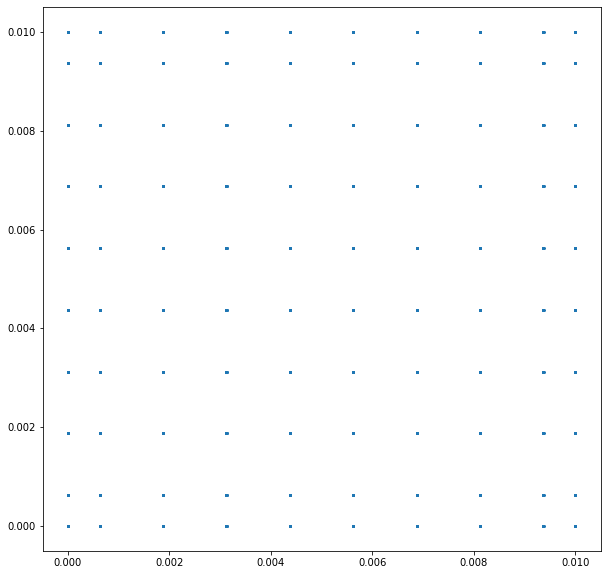

In [83]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))


# Displacement Scatter:

#
x_values = (dispx.reshape((nx+2)*(ny+2), 1) + u_new[:, 0])#*scale
y_values = (dispy.reshape((nx+2)*(ny+2), 1) + u_new[:, 1])#*scale

print(x_values.shape)

plt.scatter(x_values, y_values, s=1)

0 10
10 20
20 30
30 40
40 50
50 60
60 70
70 80
80 90
90 100


array([[-1.000e-06],
       [ 6.240e-04],
       [ 1.874e-03],
       [ 3.124e-03],
       [ 4.374e-03],
       [ 5.624e-03],
       [ 6.874e-03],
       [ 8.124e-03],
       [ 9.374e-03],
       [ 9.999e-03]])

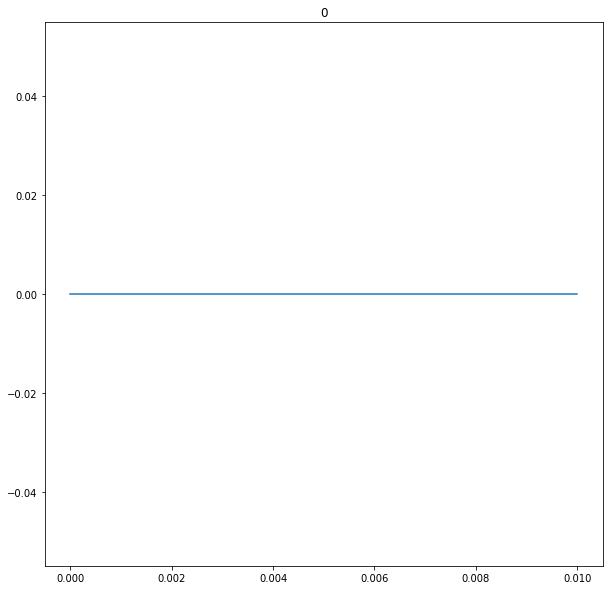

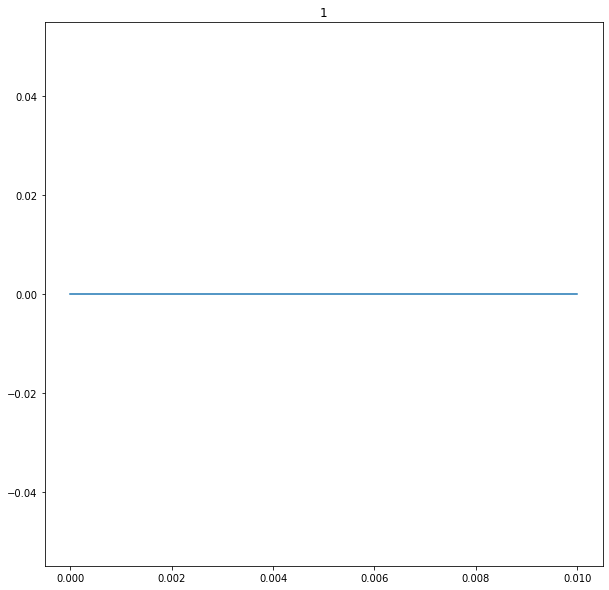

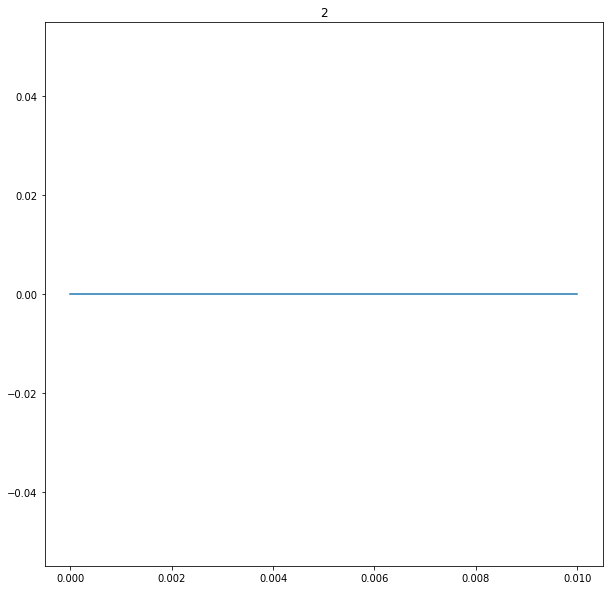

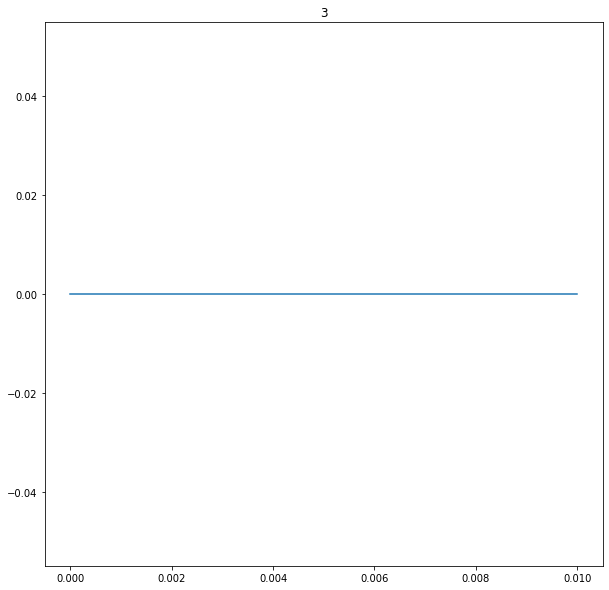

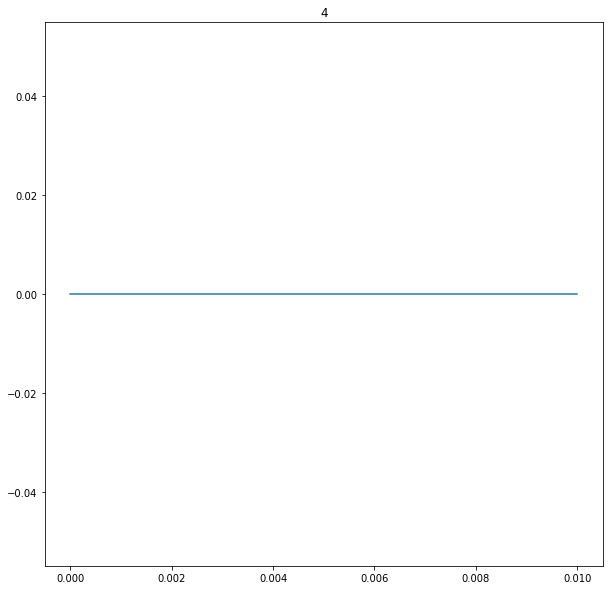

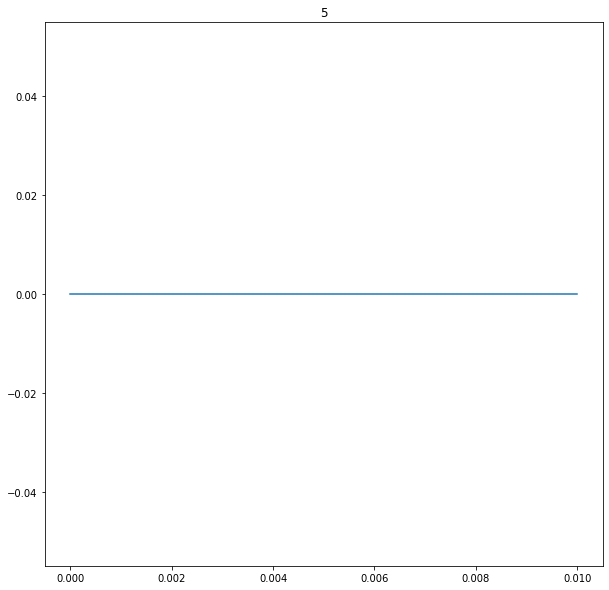

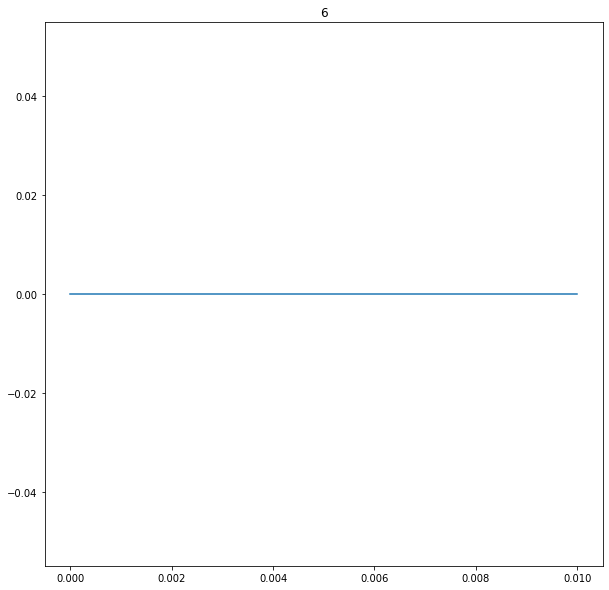

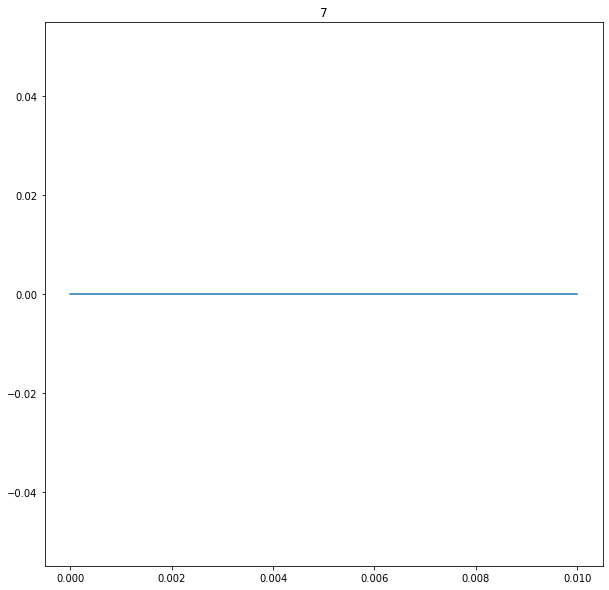

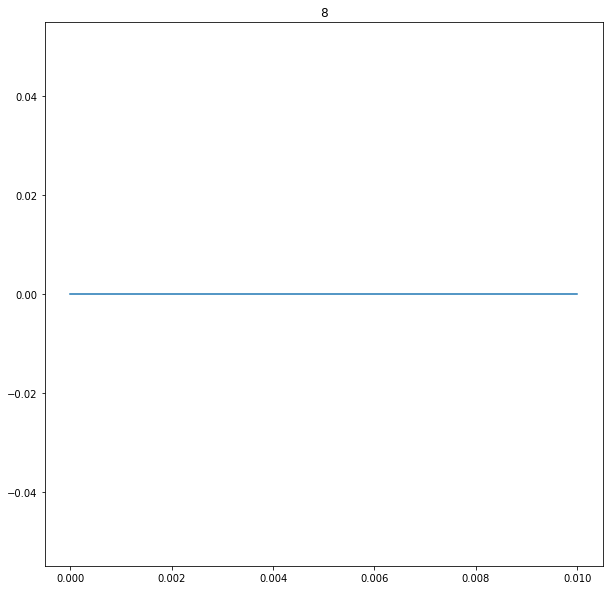

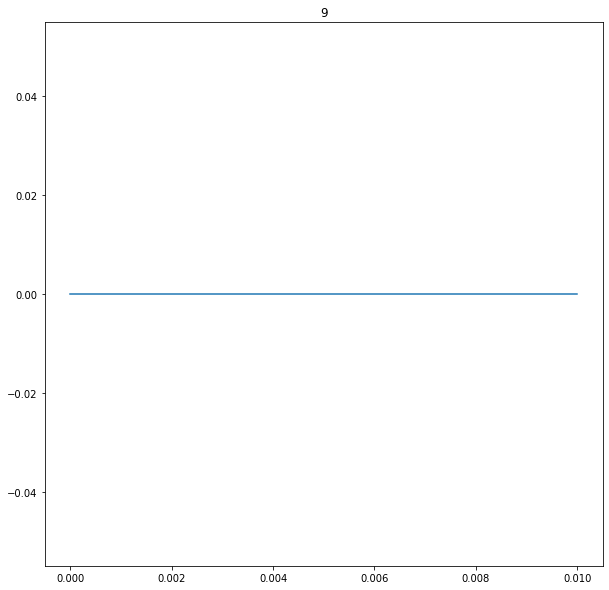

In [84]:
for i in np.arange(0,ny+2):
    
    plt.figure(figsize=(10, 10))

    print(str(0+(i*10)), str(10+(i*10)))
    
    x_values = dispx.reshape((nx+2)*(ny+2), 1)[0+(i*10):10+(i*10)] + u_new[:,0].reshape((nx+2)*(ny+2), 1)[0:10]

    y_values = u_new[:,1].reshape((nx+2)*(ny+2), 1)[0:10]

    plt.plot(x_values, y_values)
    plt.title(str(i))

    plt.show

x_values

In [85]:
u_new

array([[-1.00000000e-06, -0.00000000e+00],
       [-1.00000000e-06,  0.00000000e+00],
       [-1.00000000e-06,  0.00000000e+00],
       [-1.00000000e-06, -0.00000000e+00],
       [-1.00000000e-06, -0.00000000e+00],
       [-1.00000000e-06, -0.00000000e+00],
       [-1.00000000e-06, -0.00000000e+00],
       [-1.00000000e-06, -0.00000000e+00],
       [-1.00000000e-06, -0.00000000e+00],
       [-1.00000000e-06, -0.00000000e+00],
       [ 0.00000000e+00, -1.00000000e-06],
       [-2.74079019e-19, -2.52230543e-19],
       [-2.19808027e-18, -5.17952619e-20],
       [-2.34990238e-18, -2.09980463e-20],
       [-2.39807957e-18, -5.81696884e-21],
       [-2.39787868e-18,  5.59589124e-21],
       [-2.34936037e-18,  2.08152664e-20],
       [-2.19741126e-18,  5.16810715e-20],
       [-1.52079850e-18,  2.52197218e-19],
       [ 0.00000000e+00,  1.00000000e-06],
       [ 0.00000000e+00, -1.00000000e-06],
       [-2.72763866e-08, -4.33458154e-07],
       [ 6.25097894e-08, -1.56216065e-07],
       [ 8.

In [86]:
Ux[0], Ux[9], Ux[90], Ux[99]

(-1e-06, -1e-06, 1e-06, 1e-06)

In [87]:
Uy[0], Uy[9], Uy[90], Uy[99]

(-0.0, -0.0, 0.0, 0.0)

In [88]:
Ux[0] - Uy[0]

-1e-06